In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Matérn and Heat Kernels on Graphs
This notebook shows how define and evaluate kernels on a simple graph.
By this we mean kernels $k: V \times V \to \mathbb{R}$ where $V$ is a vertex set of a graph.
The graph **must be** undirected and have nonnegative weights.
The edges of this graph define the geometry: you expect that nodes connected by edges with large weights to be more correlated than nodes connected by edges with small weights.

At the very end of the notebook we also show how to construct *approximate finite-dimensional feature maps* for the kernels on graphs and how to use these to efficiently sample the Gaussian processes $\mathrm{GP}(0, k)$.

We use the **numpy** backend here.

**Important:** if you want to model a **signal on the edges** of a graph $G$, you can consider modeling the signal on the nodes of the [line graph](https://en.wikipedia.org/wiki/Line_graph). The line graph of $G$ has a node for each edge of $G$ and its two nodes are connected by an edge if the corresponding edges in $G$ used to share a common node. To build the line graph, you can use the [line_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.line.line_graph.html#line-graph) function of `networkx`. Alternatively, especially for the flow-type data, you might want to use specialized edge kernels.
For these, take a look into [GraphEdges.ipynb](https://geometric-kernels.github.io/GeometricKernels/examples/GraphEdges.html).
If you want to model a singal on a metric graph, take a look into [Bolin et al. (2023)](https://arxiv.org/abs/2304.10372) —owever, the machinery from this paper is not currently implemented in GeometricKernels.

<!--TABLE OF CONTENTS-->
## Contents
- [**Basics**](#Basics)
  - [Defining a Space](#Defining-a-Space)
  - [Defining a Kernel](#Defining-a-Kernel)
  - [Evaluating Kernels on Random Inputs](#Evaluating-Kernels-on-Random-Inputs)
  - [Visualizing Kernels](#Visualizing-Kernels)
  - [A Note on Prior Variance](#A-Note-on-Prior-Variance)
- [**Feature Maps and Sampling**](#Feature-Maps-and-Sampling)
  - [Defining a Feature Map](#Defining-a-Feature-Map)
  - [Efficient Sampling using Feature Maps](#Efficient-Sampling-using-Feature-Maps)
- [**Citation**](#Citation)

## Basics

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Graph
from geometric_kernels.kernels import MaternGeometricKernel

# We use networkx to visualize graphs
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.


### Defining a Space

First we create and visualize a simple *star graph* using `networkx`

In [3]:
nx_graph = nx.star_graph(6)

Define graph layout to reuse it later on (so that graph appears the same on all pictures).

In [4]:
pos = nx.spring_layout(nx_graph)

Visualize the graph.

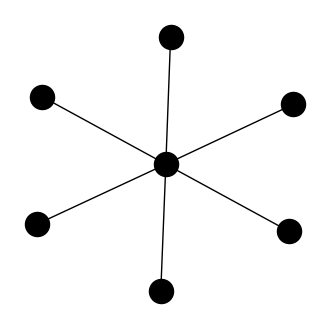

In [5]:
plt.figure(figsize=(4,4))
nx.draw(nx_graph, node_color = 'black', ax=plt.gca(), pos=pos)
plt.show()

The following cell turns the `nx_graph` created above into a GeometricKernels `Graph` space.

The `normalize_laplacian` parameter controls whether to use the eigenvectors
of the *unnormalized Laplacian* or the *symmetric normalized Laplacian* as
features (see the optional Theory section below for details).
You may want to try both `normalize_laplacian=False` and `normalize_laplacian=True` for your task.
The former is the default.

In [6]:
graph = Graph(np.array(nx.to_numpy_array(nx_graph)), normalize_laplacian=False)

### Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `graph` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on graphs can be found on this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/graphs.html).

In [7]:
kernel = MaternGeometricKernel(graph)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not provide the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [8]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array([inf]), 'lengthscale': array([1.])}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params` we define below.

**Note:** unlike the Euclidean or the manifold case, the $1/2, 3/2, 5/2$ may fail to be the reasonable values of $\nu$.
On the other hand, the parameter $\nu$ is optimizable in the same way in which the legnthscale is.
Keep in mind though, that the optimization problem may require finding some trial and error to find good a initialization and that reasonable $\kappa$ and $\nu$ will heavily depend on the specific graph in a way that is hard to predict.

**Note:** consider a graph with the scaled adjacency $\mathbf{A}' = \alpha^2 \mathbf{A}$, for some $\alpha > 0$.
Denote the kernel corresponding to $\mathbf{A}$ by $k_{\nu, \kappa}$ and the kernel corresponding to $\mathbf{A}'$ by $k_{\nu, \kappa}'$.
Then, as apparent from [the theory](https://geometric-kernels.github.io/GeometricKernels/theory/graphs.html), for the normalized graph Laplacian we have $k_{\nu, \kappa}' (i, j) = k_{\nu, \kappa} (i, j)$.
On the other hand, for the unnormalized graph Laplacian, we have $k_{\nu, \kappa}' (i, j) = k_{\nu, \alpha \cdot \kappa} (i, j)$, i.e. the lengthscale changes.

In [9]:
params["lengthscale"] = np.array([2.0])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

### Evaluating Kernels on Random Inputs

We start by sampling `3` (uniformly) random points on our graph.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [10]:
key = np.random.RandomState(1234)

key, xs = graph.random(key, 3)

print(xs)

[[3]
 [6]
 [5]]


Now we evaluate the two kernel matrices.

In [11]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

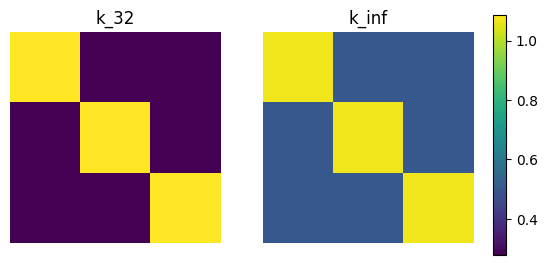

In [12]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Visualizing Kernels

Here we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
We define `base_point` and `other_points` in the next cell.

In [13]:
base_point = 1 # choosing a fixed node for kernel visualization
other_points = np.arange(graph.num_vertices)[:, None]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [14]:
values_32  = kernel.K(params_32,  np.array([[base_point]]),
                              other_points).flatten()
values_inf = kernel.K(params_inf, np.array([[base_point]]),
                              other_points).flatten()

We also evaluate the variances $k_{\nu, \kappa}(x, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [15]:
# Get prior variances k(*, *) for * in nodes:
variance_32  = kernel.K_diag(params_32,  other_points)
variance_inf = kernel.K_diag(params_inf, other_points)

Here are the actual visualization routines.

**Note:** the top right plot shows `k(base_point, *)` where `*` goes through all nodes and `base_point` has red outline. 

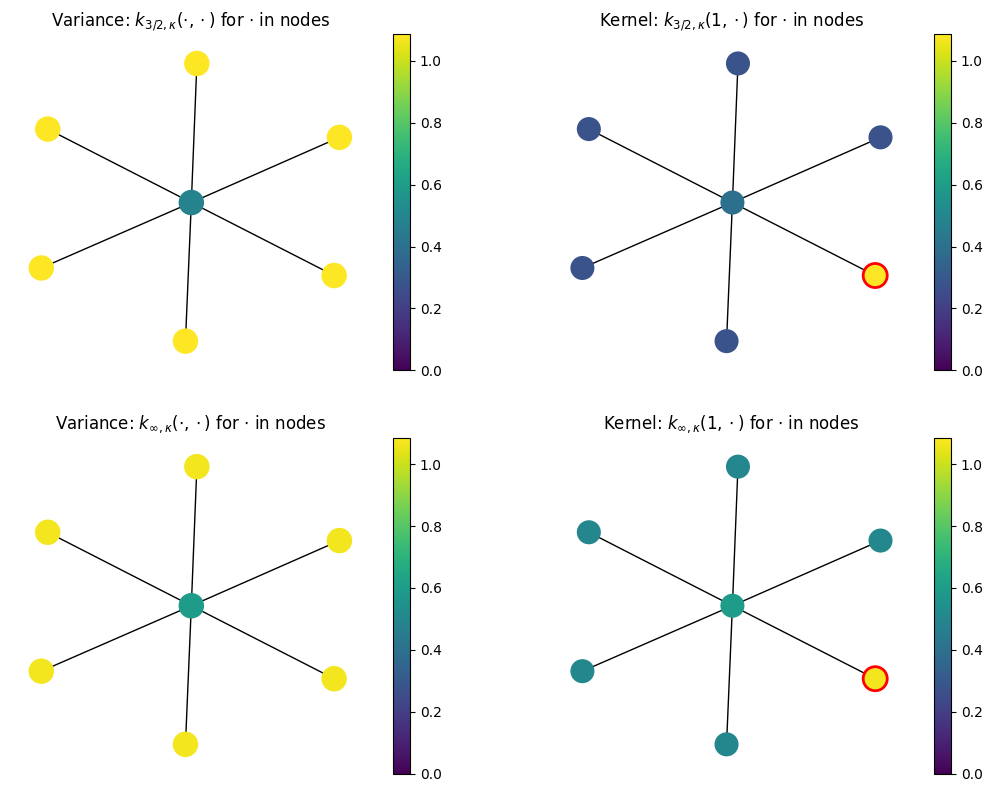

In [16]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(0.0, values_32.min(), values_inf.min())
vmax = max(1.0, variance_32.max(), variance_inf.max())


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*graph.num_vertices
edgecolors[base_point] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.8, 9.6))

# Plot variance 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=variance_32,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Variance: $k_{3/2, \kappa}(\cdot, \cdot)$ for $\cdot$ in nodes')

# Plot kernel values 32
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)

# Plot variance inf
nx.draw(nx_graph, ax=ax3, cmap=cmap, node_color=variance_inf,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax3)
ax3.set_title('Variance: $k_{\infty, \kappa}(\cdot, \cdot)$ for $\cdot$ in nodes')

# Plot kernel values inf
nx.draw(nx_graph, ax=ax4, cmap=cmap, node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax4)
ax4.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)


plt.show()

### A Note on Prior Variance

Note that the **variance changes from node to node** on this graph.

For example, for the **unnormalized Laplacian**, the variance is related to the expected *return time of a random walk*: how many steps, on average, does it take a particle
randomly walking over the graph and starting in node x to return back to node x.
For the center node, the expected return time is 2.
For other nodes, it is always higher.
Hence the variance in the center is *lower* than in the other nodes.
This argument is inspired by [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2010.15538.pdf).

For the **symmetric normalized Laplacian** the situation is different.

See this [Jupyter notebook](https://github.com/spbu-math-cs/Graph-Gaussian-Processes/blob/main/examples/graph_variance.ipynb) for more examples of how variance differs for different graphs.

In [17]:
print('Variance in the center node is %0.2f,' % variance_32[0],
      'variance in the side nodes is %0.2f.' % variance_32[1],
      'The average variance is %0.2f.' % np.mean(variance_32))

Variance in the center node is 0.49, variance in the side nodes is 1.09. The average variance is 1.00.


## Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on graphs, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

### Defining a Feature Map

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [18]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For graphs, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `Graph` space, the first element is `None` since the feature map is *deterministic*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [19]:
# xs are random points from above
_, embedding = feature_map(xs, params_32)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (3, 1)):
[[3]
 [6]
 [5]]

emedding (shape = (3, 7)):
[[-6.41113328e-01 -1.64036543e-01  3.29708720e-01  7.04784989e-01
  -2.00902915e-01 -1.71266584e-16 -4.54128597e-02]
 [-6.41113328e-01 -1.64036543e-01  2.22335923e-01 -3.90354511e-01
  -2.00902915e-01  6.35310801e-01 -4.54128597e-02]
 [-6.41113328e-01 -1.64036543e-01  2.22335923e-01 -3.90354511e-01
  -2.00902915e-01 -6.35310801e-01 -4.54128597e-02]]

||k(xs, xs) - phi(xs) * phi(xs)^T|| = 4.263892432392673e-16


### Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [20]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[-0.41701082  2.32456764]
 [-0.67512936  4.70900882]
 [-3.50324271  2.26966216]]


#### Visualizing Samples
Here we visualize samples as functions on a graph.

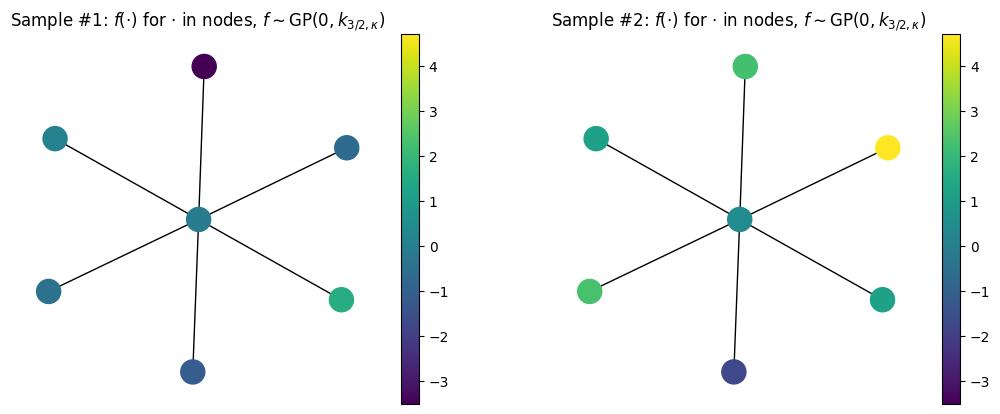

In [21]:
key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(sample1.min(), sample2.min())
vmax = max(sample1.max(), sample2.max())

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

# Plot sample #1
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=sample1,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in nodes, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Plot sample #2
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=sample2,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in nodes, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')

plt.show()

# Prediction

In [22]:
# problem definition

x_base = np.array([[1]])
y_base = np.array([[1]])

x_pred = np.arange(0,graph.num_vertices)[...,None]

# pred 

kernel_mat_32 = kernel.K(params_32, x_pred, x_base)
kernel_mat_32_base = kernel.K(params_32, x_base, x_base)

values_32 = (kernel_mat_32 / (np.diag(kernel_mat_32_base) + 1e-10)) @ y_base # shouldn't take everything, only contact (* adj_matrix)
print("values_32:",values_32)

kernel_mat_inf = kernel.K(params_inf, x_pred, x_base)
kernel_mat_inf_base = kernel.K(params_inf, x_base, x_base)

values_inf = (kernel_mat_inf / (np.diag(kernel_mat_inf_base) + 1e-10)) @ y_base
print("values_inf:",values_inf)


values_32: [[0.36715474]
 [1.        ]
 [0.25654051]
 [0.25654051]
 [0.25654051]
 [0.25654051]
 [0.25654051]]
values_inf: [[0.5588286 ]
 [1.        ]
 [0.47059497]
 [0.47059497]
 [0.47059497]
 [0.47059497]
 [0.47059497]]


vmin,vmax 0.25654051086282 0.999999999907901


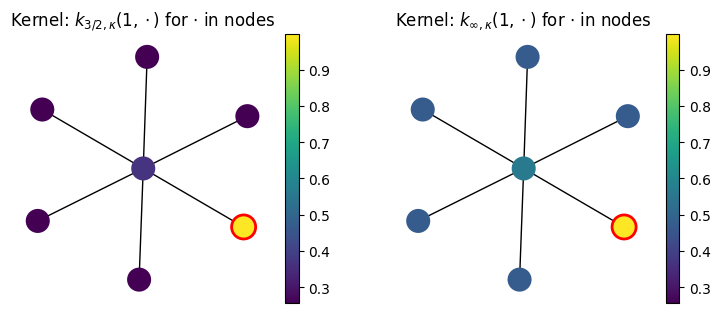

In [23]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(values_32.min(), values_inf.min())
vmax = max(values_32.max(), values_inf.max())
print("vmin,vmax",vmin,vmax)


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*graph.num_vertices
edgecolors[base_point] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5))

# Plot kernel values 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)

# Plot kernel values inf
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)


plt.show()

In [24]:
params_32["lengthscale"] = np.array([4.0])
params_inf["lengthscale"] = np.array([4.0])

# problem definition

x_base = np.array([[1]])
y_base = np.array([[1]])

x_pred = np.arange(0,graph.num_vertices)[...,None]

# pred 

kernel_mat_32 = kernel.K(params_32, x_pred, x_base)
kernel_mat_32_base = kernel.K(params_32, x_base, x_base)

values_32 = (kernel_mat_32 / (np.diag(kernel_mat_32_base) + 1e-10)) @ y_base # shouldn't take everything, only contact (* adj_matrix)
print("values_32:",values_32)

kernel_mat_inf = kernel.K(params_inf, x_pred, x_base)
kernel_mat_inf_base = kernel.K(params_inf, x_base, x_base)

values_inf = (kernel_mat_inf / (np.diag(kernel_mat_inf_base) + 1e-10)) @ y_base
print("values_inf:",values_inf)


values_32: [[0.72861112]
 [1.        ]
 [0.67864945]
 [0.67864945]
 [0.67864945]
 [0.67864945]
 [0.67864945]]
values_inf: [[0.99804696]
 [1.        ]
 [0.99765635]
 [0.99765635]
 [0.99765635]
 [0.99765635]
 [0.99765635]]


vmin,vmax 0.6786494511019445 0.9999999999035687


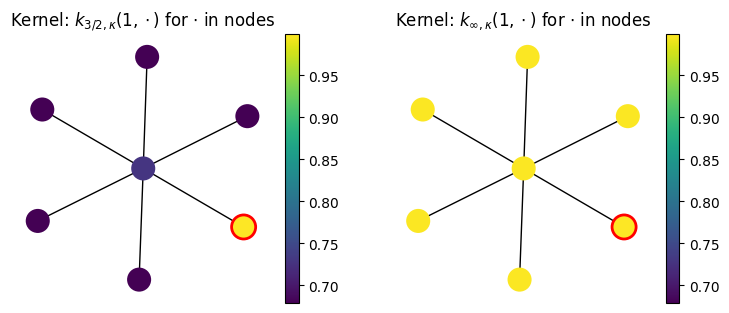

In [25]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(values_32.min(), values_inf.min())
vmax = max(values_32.max(), values_inf.max())
print("vmin,vmax",vmin,vmax)


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*graph.num_vertices
edgecolors[base_point] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5))

# Plot kernel values 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)

# Plot kernel values inf
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)


plt.show()

## Path graph

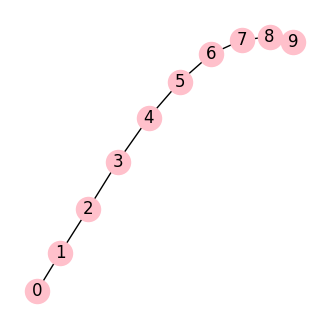

params: {'nu': array([inf]), 'lengthscale': array([1.])}


In [26]:
nx_graph = nx.path_graph(10)
pos = nx.spring_layout(nx_graph)

plt.figure(figsize=(4,4))
nx.draw(nx_graph, node_color = 'pink', ax=plt.gca(), pos=pos)
nx.draw_networkx_labels(nx_graph,pos=pos,labels={k:str(k) for k in np.arange(nx_graph.number_of_nodes())})
plt.show()


graph = Graph(np.array(nx.to_numpy_array(nx_graph)), normalize_laplacian=False)

kernel = MaternGeometricKernel(graph)
params = kernel.init_params()
print('params:', params)

params["lengthscale"] = np.array([2.0])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

values_32: [[0.45819871]
 [0.65547051]
 [1.        ]
 [0.59837324]
 [0.31360846]
 [0.15558614]
 [0.07505223]
 [0.03594271]
 [0.01795496]
 [0.01099588]]
values_inf: [[0.82660773]
 [0.94656353]
 [1.        ]
 [0.83969062]
 [0.54744767]
 [0.28349264]
 [0.12013888]
 [0.04281758]
 [0.01326597]
 [0.00433258]]


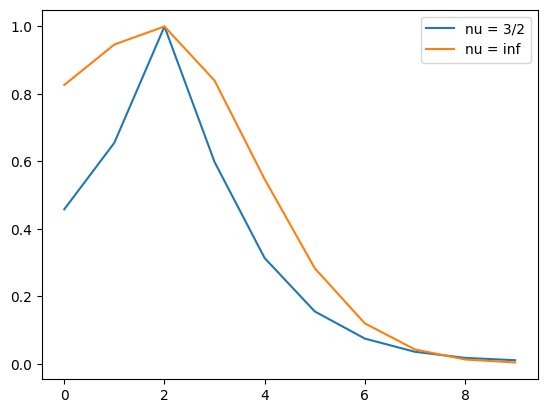

In [27]:
# problem definition

x_base = np.array([[2]])
y_base = np.array([[1]])

x_pred = np.arange(0,graph.num_vertices)[...,None]

# pred 

kernel_mat_32 = kernel.K(params_32, x_pred, x_base)
kernel_mat_32_base = kernel.K(params_32, x_base, x_base)

values_32 = (kernel_mat_32 / (np.diag(kernel_mat_32_base) + 1e-10)) @ y_base # shouldn't take everything, only contact (* adj_matrix)
print("values_32:",values_32)

kernel_mat_inf = kernel.K(params_inf, x_pred, x_base)
kernel_mat_inf_base = kernel.K(params_inf, x_base, x_base)

values_inf = (kernel_mat_inf / (np.diag(kernel_mat_inf_base) + 1e-10)) @ y_base
print("values_inf:",values_inf)


plt.plot(values_32, label = "nu = 3/2")
plt.plot(values_inf, label = "nu = inf")
plt.legend()
plt.show()

vmin,vmax 0.004332579235014278 0.9999999998878912


/tmp/ipykernel_21743/2303049033.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  edgecolors[int(x_base)] = (1, 0, 0, 1)


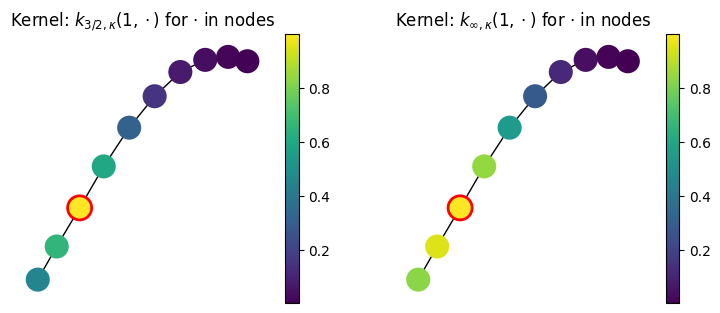

In [28]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(values_32.min(), values_inf.min())
vmax = max(values_32.max(), values_inf.max())
print("vmin,vmax",vmin,vmax)


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*graph.num_vertices
edgecolors[int(x_base)] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5))

# Plot kernel values 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, 
        node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)

# Plot kernel values inf
nx.draw(nx_graph, ax=ax2, cmap=cmap,
        node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)


plt.show()

## Balanced tree

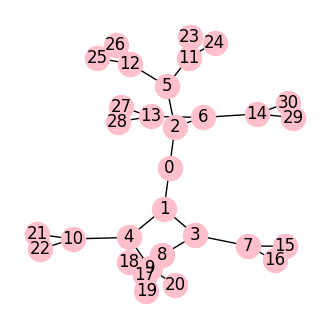

In [29]:
nx_graph = nx.balanced_tree(2, 4)
pos = nx.spring_layout(nx_graph)

plt.figure(figsize=(4,4))
nx.draw(nx_graph, node_color = 'pink', ax=plt.gca(), pos=pos)
nx.draw_networkx_labels(nx_graph,pos=pos,labels={k:str(k) for k in np.arange(nx_graph.number_of_nodes())})
plt.show()


In [30]:
graph = Graph(np.array(nx.to_numpy_array(nx_graph)), normalize_laplacian=False)

kernel = MaternGeometricKernel(graph)
params = kernel.init_params()
print('params:', params)

params["lengthscale"] = np.array([2.0])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

params: {'nu': array([inf]), 'lengthscale': array([1.])}


In [31]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [32]:
import scipy.linalg

# problem definition

x_base = np.array([[5],
                   [7]])
y_base = np.array([[1],
                   [1]])

x_pred = np.arange(0,graph.num_vertices)[...,None]

# pred 

kernel_mat_32 = kernel.K(params_32, x_pred, x_base)
print("kernel_mat_32.shape",kernel_mat_32.shape)
kernel_mat_32_base = kernel.K(params_32, x_base, x_base)
print("kernel_mat_32_base.shape",kernel_mat_32_base.shape)

values_32 = (kernel_mat_32 @ (scipy.linalg.inv(kernel_mat_32_base) + 1e-10 * np.eye(y_base.shape[0]))) @ y_base # shouldn't take everything, only contact (* adj_matrix)
print("values_32:",values_32)

kernel_mat_inf = kernel.K(params_inf, x_pred, x_base)
kernel_mat_inf_base = kernel.K(params_inf, x_base, x_base)

values_inf = (kernel_mat_inf @ (scipy.linalg.inv(kernel_mat_inf_base)  + 1e-10 * np.eye(y_base.shape[0]))) @ y_base
print("values_inf:",values_inf)

kernel_mat_32.shape (31, 2)
kernel_mat_32_base.shape (2, 2)
values_32: [[0.32567518]
 [0.26698653]
 [0.50181271]
 [0.47503309]
 [0.10250332]
 [1.        ]
 [0.2080113 ]
 [1.        ]
 [0.22897533]
 [0.04484482]
 [0.04484482]
 [0.59128286]
 [0.59128286]
 [0.09570837]
 [0.09570837]
 [0.8210048 ]
 [0.8210048 ]
 [0.15200372]
 [0.15200372]
 [0.02827061]
 [0.02827061]
 [0.02827061]
 [0.02827061]
 [0.42390563]
 [0.42390563]
 [0.42390563]
 [0.42390563]
 [0.06210694]
 [0.06210694]
 [0.06210694]
 [0.06210694]]
values_inf: [[0.65548066]
 [0.48518223]
 [0.75141381]
 [0.61590199]
 [0.19304242]
 [1.        ]
 [0.40453077]
 [1.        ]
 [0.34175718]
 [0.07237833]
 [0.07237833]
 [0.99866831]
 [0.99866831]
 [0.20758726]
 [0.20758726]
 [1.13321747]
 [1.13321747]
 [0.23819469]
 [0.23819469]
 [0.03492526]
 [0.03492526]
 [0.03492526]
 [0.03492526]
 [0.95334453]
 [0.95334453]
 [0.95334453]
 [0.95334453]
 [0.13141141]
 [0.13141141]
 [0.13141141]
 [0.13141141]]


vmin,vmax 0.02827061443995519 1.1332174669367068


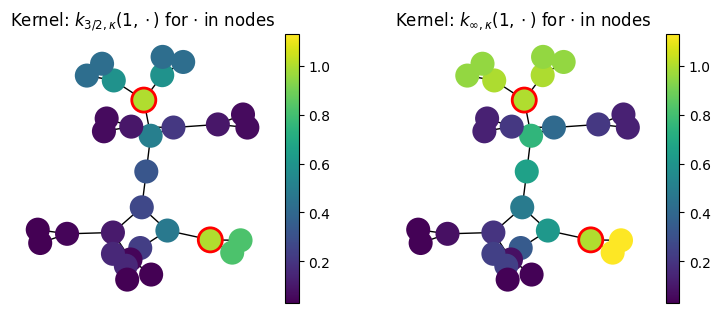

In [33]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(values_32.min(), values_inf.min())
vmax = max(values_32.max(), values_inf.max())
print("vmin,vmax",vmin,vmax)


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*graph.num_vertices
for id in x_base.flatten():
        edgecolors[int(id)] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5))

# Plot kernel values 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, 
        node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)

# Plot kernel values inf
nx.draw(nx_graph, ax=ax2, cmap=cmap,
        node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)


plt.show()

# Prediction - optimization

In [34]:

# in sklearn fit:
"""opt_res = scipy.optimize.minimize(
                obj_func,
                initial_theta,
                method="L-BFGS-B",
                jac=True,
                bounds=bounds,
            )"""

'opt_res = scipy.optimize.minimize(\n                obj_func,\n                initial_theta,\n                method="L-BFGS-B",\n                jac=True,\n                bounds=bounds,\n            )'

In [35]:
length_scale_bounds=(1e-05, 100000.0)

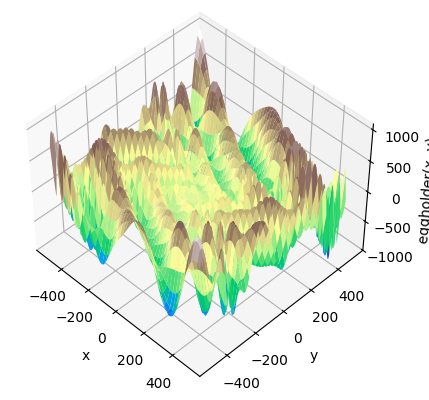

In [36]:
def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
            -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

bounds = [(-512, 512), (-512, 512)]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')
plt.show()

In [37]:
import scipy.optimize

initial_theta = np.random.uniform(np.array(bounds)[:,0],np.array(bounds)[:,1])
print("initial_theta\n",initial_theta)
scipy.optimize.minimize(eggholder, 
                        x0 = initial_theta,
                        method="L-BFGS-B",
                        jac=False,
                        bounds=np.array(bounds),
                        options={"workers":1}
                        )



scipy.optimize.dual_annealing(eggholder,
                              bounds=np.array(bounds))

initial_theta
 [-297.4953076   167.10309743]


/tmp/ipykernel_21743/4241160976.py:5: OptimizeWarning: Unknown solver options: workers
  scipy.optimize.minimize(eggholder,


 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -956.9182316222481
       x: [ 4.824e+02  4.329e+02]
     nit: 1000
    nfev: 4160
    njev: 53
    nhev: 0

In [38]:
import scipy.sparse

edge_index = np.array([[0,1,2,3,4],
                       [1,2,3,4,4]])
edge_weight = np.array([1,1,2,2,2])


def convert_to_adj_matrix(num_nodes:int,edge_index:np.ndarray,edge_weight:np.ndarray | None = None):
    if edge_weight is None:
        _edge_weight = np.ones(edge_index.shape[1])
    else:
        _edge_weight = np.copy(edge_weight)

    adj_matrix = scipy.sparse.coo_matrix((_edge_weight, (edge_index[0,:], edge_index[1,:])), shape=(num_nodes, num_nodes)).toarray()
    return adj_matrix

num_nodes = np.max(edge_index)+1 # for here
convert_to_adj_matrix(num_nodes=num_nodes,edge_index=edge_index,edge_weight=edge_weight)

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 2]])

In [39]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go

from typing import Optional, Iterable
from torch_geometric.data import Data

def convert_torch_to_networkx_graph(data: Data, edge_attr_id: int = 0, to_undirected:bool|str = False):
    # TODO: allow data not to have edge_attr
    G = to_networkx(data, to_undirected=to_undirected)
    weights = {e_pair:float(data.edge_attr[e,edge_attr_id]) for e,e_pair in enumerate(G.edges())} 
    nx.set_edge_attributes(G, values = weights, name = 'weight')
    return G


/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


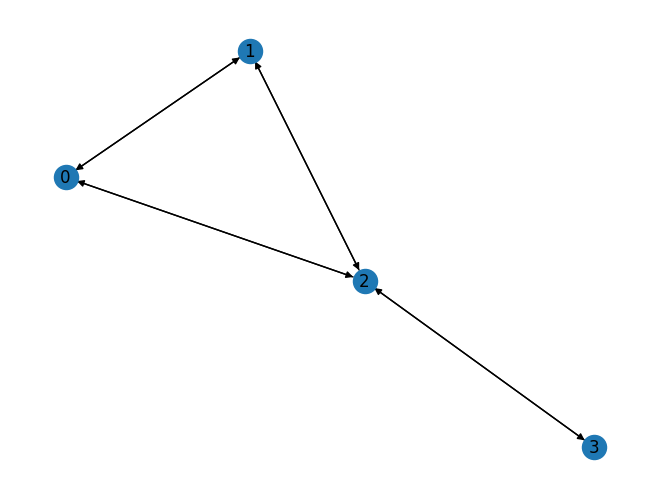

[[0.99999952]
 [0.99999964]
 [0.99999952]
 [1.        ]]
{'lengthscale_opt': [array([2.50000728])], 'func_min': [np.float64(7.484872520375439e-12)], 'val_mae': []}


In [41]:
import copy
import torch
import torch_geometric.transforms as T


class MaternKernelModel():
    def __init__(self,nu: float = np.inf):
        assert isinstance(nu,float), ("nu: "+str(nu)) 
        self.nu = nu

        # init_kernel before use
        self.kernel = None
        self.params = {}
        self.params["nu"] = np.array([self.nu])
        self.params["lengthscale"] =  np.array([1.0]) # default value


    def init_kernel(self,
                    num_nodes:int,
                    edge_index:torch.Tensor,
                    edge_weight:torch.Tensor):
        adj_matrix = convert_to_adj_matrix(num_nodes,edge_index.numpy(), edge_weight = edge_weight.numpy())
        graph = Graph(np.array(adj_matrix), normalize_laplacian=False)
        self.kernel = MaternGeometricKernel(graph)
        return self
    

    def predict(self,
                num_nodes:int,
                edge_index:torch.Tensor,
                edge_weight:torch.Tensor,
                x_pred_mask:torch.Tensor,
                x_base_mask:torch.Tensor,
                y_base:torch.Tensor):
        self.init_kernel(num_nodes,edge_index,edge_weight)
        x_pred = torch.where(x_pred_mask)[0].numpy()[...,None]
        x_base = torch.where(x_base_mask)[0].numpy()[...,None]
        kernel_mat = self.kernel.K(self.params, x_pred, x_base)
        kernel_mat_base = self.kernel.K(self.params, x_base, x_base)
        y_pred = (kernel_mat @ (scipy.linalg.inv(kernel_mat_base + 1e-10 * np.eye(y_base.size(dim=0))))) @ y_base.numpy()
        return y_pred 


    def fit(self,
            dataset,
            edge_weight_name:str,
            val_dataset = None, 
            bounds = [(1e-5,1e5)],
            **kwargs):
        batch_graph = next(iter(dataset))
        assert hasattr(batch_graph,"edge_attr_names"),batch_graph
        is_validation_present = hasattr(batch_graph,"val_mask")

        def obj_func(theta,
                     num_nodes,
                     edge_index,
                     edge_weight,
                     y_true, 
                     x_pred_mask, 
                     x_base_mask,
                     y_base):
            self.params["lengthscale"] = theta
            y_pred = self.predict(
                num_nodes = num_nodes,
                edge_index = edge_index,
                edge_weight = edge_weight,
                x_pred_mask = x_pred_mask,
                x_base_mask = x_base_mask,
                y_base = y_base)
            return np.power(np.linalg.norm(y_pred - y_true.numpy(),ord=2),2) # only MSE see for log-marginal-likelihood
        

        history = {"lengthscale_opt":[],"func_min":[],"val_mae":[]}

        for batch_graph in dataset:
            train_mask = batch_graph.train_mask
            
            if is_validation_present:
                val_mask = batch_graph.val_mask
            
            if hasattr(batch_graph,"base_mask"):
                base_mask = batch_graph.base_mask
            else:
                base_mask = torch.ones(batch_graph.num_nodes).to(torch.bool)
                base_mask[train_mask] = False
                base_mask[val_mask] = False

            edge_weight_id = np.where(np.array(batch_graph.edge_attr_names) == edge_weight_name)[0][0]
            
            opt_res = scipy.optimize.dual_annealing(
                lambda theta: obj_func(theta=theta,
                                       num_nodes = batch_graph.num_nodes,
                                       edge_index = batch_graph.edge_index,
                                       edge_weight = batch_graph.edge_attr[:,edge_weight_id],
                                       y_true = batch_graph.y[train_mask],
                                       x_pred_mask = train_mask,
                                       x_base_mask = base_mask,
                                       y_base = batch_graph.y[base_mask]), 
                bounds=np.array(bounds)
            )

            lengthscale_opt, func_min = opt_res.x, opt_res.fun
            history["lengthscale_opt"].append(lengthscale_opt)
            history["func_min"].append(func_min)
            
        self.params["lengthscale"] = lengthscale_opt # last one
        return history

matern_model = MaternKernelModel(nu = np.inf)


graph = Data(
    x = torch.Tensor([[0],
                      [1],
                      [2],
                      [2]]),
    y = torch.Tensor([[0.80153107],
                      [0.3940955 ],
                      [1.        ],
                      [1.]]),
    edge_index = torch.Tensor([[0,1,2,2],
                           [1,2,3,0]]).to(torch.int64),
    edge_attr = torch.Tensor([[1],
                              [0.5],
                              [1],
                              [1]]),
    edge_attr_names = ["weight_name"],
    train_mask = torch.Tensor([True,False,False,False]).to(bool),
    val_mask = torch.Tensor([False,False,False,False]).to(bool),
    base_mask = torch.Tensor([False,False,False,True]).to(bool)
)

transform = T.Compose([T.ToUndirected()])
graph = transform(graph)

nx.draw_spring(convert_torch_to_networkx_graph(graph), with_labels=True)
plt.show()

matern_model.params["lengthscale"] = np.array([7.5])

y_pred = matern_model.predict(
    edge_index = graph.edge_index,
    edge_weight = graph.edge_attr[:,0],
    num_nodes = graph.num_nodes,
    x_pred_mask = torch.Tensor([True,True,True,True]),
    x_base_mask = torch.Tensor([False,False,False,True]),
    y_base = torch.Tensor([[1]])
)

print(y_pred)

if True:
    history = matern_model.fit(
        dataset=[graph],
        edge_weight_name="weight_name",
        bounds = [(1e-5,1e2)]
    )
    print(history)

In [ ]:
A = np.array(["a","b","c"])
print(A)
print(np.where(A == "b")[0][0])

['a' 'b' 'c']
1


In [ ]:
A = torch.Tensor(["a","b","c"])

ValueError: too many dimensions 'str'

In [ ]:
convert_to_adj_matrix(
    edge_index=graph.edge_index.numpy(),
    edge_weight=graph.edge_attr[:,0].numpy(),
    num_nodes=graph.num_nodes)

array([[0. , 1. , 1. , 0. ],
       [1. , 0. , 0.5, 0. ],
       [1. , 0.5, 0. , 1. ],
       [0. , 0. , 1. , 0. ]], dtype=float32)

In [ ]:
for batch_i, batch_graph in enumerate(dataset):
                batch_node_attr = batch_graph.x.to(self.device)
                batch_edge_index = batch_graph.edge_index.to(self.device)
                batch_edge_attr = batch_graph.edge_attr.to(self.device) if not(batch_graph.edge_attr is None) else None
                batch_labels = batch_graph.y.to(self.device)
                batch_train_mask = batch_graph.train_mask.to(self.device)

In [ ]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X, y)
gpr.score(X, y)
gpr.predict(X[:2,:], return_std=True)

/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(array([653.08792288, 592.16905327]), array([316.68016218, 316.65121679]))

In [ ]:
y[:2]

array([781.91445769, 518.44313575])

## Citation

If you are using graphs and GeometricKernels, please consider citing

```
@article{mostowsky2024,
      title = {The GeometricKernels Package: Heat and Matérn Kernels for Geometric Learning on Manifolds, Meshes, and Graphs},
      author = {Peter Mostowsky and Vincent Dutordoir and Iskander Azangulov and Noémie Jaquier and Michael John Hutchinson and Aditya Ravuri and Leonel Rozo and Alexander Terenin and Viacheslav Borovitskiy},
      year = {2024},
      journal = {arXiv:2407.08086},
}
```

```
@inproceedings{borovitskiy2021,
    title={Matérn Gaussian processes on graphs},
    author={Borovitskiy, Viacheslav and Azangulov, Iskander and Terenin, Alexander and Mostowsky, Peter and Deisenroth, Marc and Durrande, Nicolas},
    booktitle={International Conference on Artificial Intelligence and Statistics},
    year={2021}
}
```

```
@inproceedings{kondor2002,
    title={Diffusion Kernels on Graphs and Other Discrete Structures},
    author={Kondor, Risi Imre and Lafferty, John},
    booktitle={International Conference on Machine Learning},
    year={2002}
}
```